In [1]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### データ作成

In [2]:
# シンプルデータセット2作成コード

X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

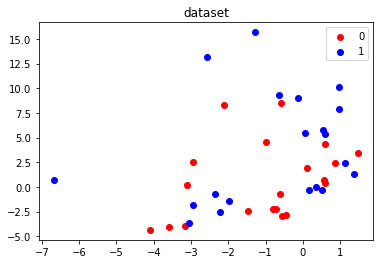

In [3]:
# データ確認
plt.title("dataset")
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='r', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b', label='1')
plt.legend()
plt.show()

# 決定木スクラッチ

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

In [4]:
class _Node:
    """決定木のノードを生成するクラス"""
    
    def __init__(self, depth=0):
        """初期化処理
        depth : 現在の階層
        left : 左の子ノード
        right : 右の子ノード
        feature : 分割する特徴量のcolumn番号
        threshold : 分割する閾値
        label : クラス
        num_data : データの行数
        ig : 分割指標(情報利得)
        """
        self.depth = depth
        self.l_node = None
        self.r_node = None
        
        self.threshold = None
        self.label = None
        self.n_data = None
        self.ig = None
        
    def build(self, data, target, max_depth):
        """木の構築を行う
        data : ノードに与えられたデータ
        target : データの分類クラス
        
        """
        
        self.feature = None
        self.max_depth = max_depth
        self.n_data = data.shape[0]
        n_features = data.shape[1]
        
        # 自分のクラスを設定
        classes, counts = np.unique(target, return_counts=True) 
        if len(classes) == 1:
            self.label = classes[0]
        else:
            self.label = counts.argmax() 

        # デバッグ用表示
        """
        print("==================")
        print("現在のノードのサンプル数:{}".format(self.n_data))
        print("現在のノードのクラス比率:{}".format(counts))
        print("現在のノードの深さ:{}".format(self.depth))
        print("現在のノードのクラス:{}".format(self.label))
        print("==================")
        """
        
        # max_depthに到達してたら終わり
        if max_depth == None:
            pass
        elif self.depth >= max_depth:
            #print("Reach for the max depth.")
            return
        
        # 全部同一クラスでも終わり
        if len(classes) == 1:
            #print("This node is a single class")
            return
        
        
        # 最良の分割を記憶する変数
        best_ig = 0.0
        best_feature = None
        best_threshold =None

        # 自分の不純度
        self.gini = self._ginis_diversity_index(target)
        
        
        # 特徴量ごとに分割していく
        for f in range(n_features):
            for threshold in data:
                index_classifier = data[:,f] <  threshold[f]
                target_l = target[index_classifier]
                target_r = target[~index_classifier]

                # 分割後の不純度から情報利得を計算
                ig = self._information_gain(target_l, target_r)
                
                # より良い分割であれば保存
                if ig > best_ig:
                    best_ig = ig
                    best_feature = f
                    best_threshold = threshold
    
        
        # 最良の分割をインスタンス化
        self.ig = best_ig
        self.feature = best_feature
        self.threshold = best_threshold
        
        
        # 次のノードに進むための準備
        
        # dataとtargetを実際に分割する
        index_classifier = data[:,self.feature] < self.threshold[self.feature]
        data_l = data[index_classifier]
        data_r = data[~index_classifier]
        target_l = target[index_classifier]
        target_r = target[~index_classifier]
        
        _, l_counts = np.unique(target_l, return_counts=True)
        _, r_counts = np.unique(target_r, return_counts=True)
        self.l_label = l_counts.argmax() 
        self.r_label = r_counts.argmax() 
        
        # 次の深さ
        next_depth = self.depth + 1
        
        # 子ノードをインスタンス化して再帰処理
        self.l_node = _Node(next_depth)
        self.l_node.build(data_l, target_l, max_depth)
        
        self.r_node = _Node(next_depth)
        self.r_node.build(data_r, target_r, max_depth)
        
        
        
    
    # ジニ不純度を計算する関数
    def _ginis_diversity_index(self, target):
        _, counts = np.unique(target, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        n_all = len(target) # arrayのサンプル総数

        # giniの計算
        gini = 1 - (np.sum((counts / n_all)**2))

        return gini
    
    
    # 情報利得を計算する関数
    def _information_gain(self, left, right):
        n_l = left.shape[0] 
        n_r = right.shape[0]

        left_gini = self._ginis_diversity_index(left)
        right_gini = self._ginis_diversity_index(right)
        
        ig = self.gini - n_l / self.n_data * left_gini - n_r / self.n_data * right_gini

        return ig
    
    # 推測する関数
    def predict(self, d):
        """
        1行の配列を受け取って個別に推測している。
        """
        if self.feature == None or self.depth == self.max_depth:
            return self.label
        
        else:
            if d[self.feature] < self.threshold[self.feature]:
                #print(self.feature)
                return self.l_node.predict(d)
            else:
                return self.r_node.predict(d)
        
        
class ScratchDecesionTreeClassifier:
    """
    メインクラス。
    """
    def __init__(self, max_depth=None):
        self.root_node = None
        self.max_depth = max_depth
            
            
    # メイン部分
    def fit(self, data, target):
        """学習を行い決定木を構築する
        data : 学習データ
        target : データの分類クラス
            
        """
        self.root_node = _Node()
        self.root_node.build(data, target, self.max_depth)
            
            
    # 推測する
    def predict(self, data):
        """
        決定木分類器を使いラベルを推定する
        """
        ans = []
        
        for d in data:
            ans.append(self.root_node.predict(d))
        return np.array(ans)
            
            

        
    

In [5]:
temp = ScratchDecesionTreeClassifier()

In [6]:
temp.fit(X, y)

In [59]:
temp_pred = temp.predict(X)

## 分割の条件を学習で求める
学習によって、ノードをどういった条件で分割すると、うまく分けられるかということを求めます。


うまく分けられていることを判定するためにノードに対してジニ不純度と情報利得という値を計算します。

# 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード 
$t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t)=1−K∑i=1P2(Ci|t)=1−K∑i=1(Nt,iNt,all)2
$$

$t$ : ノードのインデックス

$i$ : クラスのインデックス

$K$ : クラスの数

$Ci$ : i番目のクラス

$P(Ci|t)$:　t番目のノードにおける$Ci$の割合

$Nt,i$ : t番目のノードのi番目のクラスに属するサンプル数

$Nt,all$ : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


* クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
* クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
* クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
* クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000


### データ作成

In [8]:
# サンプルのndarrayを作成する関数、ランダムか等分割合か
def init_ndarray(label = 2, all_samples = 120, random=False):
    if random == True:
        array = np.random.randint(0, label, size = all_samples)
    else:  
        n_sample = all_samples // label
        array = np.zeros(all_samples)
        for i in range(label):
            for j in range(n_sample):
                x = i * n_sample
                array[j + x] = i
    return array

In [9]:
sample1 = init_ndarray(2, 30, False)
sample2 = init_ndarray(3, 45, False)
sample3 = init_ndarray(2, 30, False)
sample3[15:18] = 0
sample4 = init_ndarray(1, 30, False)
print(sample1)
print(sample2)
print(sample3)
print(sample4)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


### 【解答】自作関数

In [10]:
# ジニ不純度を計算する関数
def ginis_diversity_index(array):
    _, counts = np.unique(array, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
    n_all = len(array) # arrayのサンプル総数
    
    # giniの計算
    gini = 1 - (np.sum((counts / n_all)**2))

    return gini, counts
    

### 【検証】自作関数で例題を解いてみる

In [11]:
pd.options.display.precision = 3
sample_gini_1, counts1 = ginis_diversity_index(sample1)
sample_gini_2, counts2 = ginis_diversity_index(sample2)
sample_gini_3, counts3 = ginis_diversity_index(sample3)
sample_gini_4, counts4 = ginis_diversity_index(sample4)

tmp = pd.DataFrame(data = [counts1,counts2,counts3,counts4], index=["例1","例2","例3","例4"])
gini_list = [sample_gini_1,sample_gini_2,sample_gini_3,sample_gini_4]
t  = [0.500, 0.667, 0.480, 0.000]
tmp["理論値"] = t
tmp["計算値"] = gini_list
display(tmp)

,0,1,2,理論値,計算値
例1,15,15.0,NaN,0.500,0.500
例2,15,15.0,15.0,0.667,0.667
例3,18,12.0,NaN,0.480,0.480
例4,30,NaN,NaN,0.000,0.000


同じ結果を得られた。

---

# 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 
$I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$$
IG(p)=I(p)−\frac{N_{left,all}}{N_{p,all}}I(left)−\frac{N_{right,all}}{N_{p,all}}I(right)
$$

$p$ : 親ノードを示すインデックス

$left$ : 左側のノードを示すインデックス

$right$ : 右側のノードを示すインデックス


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》

左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

### データ作成

In [12]:
# サンプル配列の作成
sampleX = np.concatenate([np.zeros(30), np.ones(35)])
left_sampleX = np.concatenate([np.zeros(10), np.ones(30)])
right_sampleX = np.concatenate([np.zeros(20), np.ones(5)])
sampleX, left_sampleX, right_sampleX

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1.]))

### 【解答】自作関数

In [13]:
# 情報利得を計算する関数
def information_gain(root, left, right):
    N_all = len(root)
    N_l = len(left) # arrayのサンプル総数
    N_r = len(right) # arrayのサンプル総数
    
    gini,_ = ginis_diversity_index(root)
    #print(gini)
    left_gini,_ = ginis_diversity_index(left)
    #print(left_gini)
    right_gini,_ = ginis_diversity_index(right)
    #print(right_gini)
    
    #print((N_l / N_all))
    #print((N_r / N_all))
    
    ig = gini - N_l / N_all * left_gini - N_r / N_all * right_gini 
    
    return ig


### 【検証】自作関数で例題を解いてみる

In [14]:
ig_test = information_gain(sampleX, left_sampleX, right_sampleX)
print("例題の条件：左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5")
print("例題の答え：情報利得0.143")
print("自作関数の出力：{:.3f}".format(ig_test))

例題の条件：左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5
例題の答え：情報利得0.143
自作関数の出力：0.143


同一の出力を得られたため、問題なし。

---

# 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


《組み合わせの取り方》


全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


《補足》


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。



### データ作成

In [15]:
# シンプルデータセット2作成コード
# 学習用に使う

X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.75, random_state=0)

In [17]:
# 可視化関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region on 3-nn', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスタンスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### 【解答】自作関数

In [18]:
# 問題3用のクラス
class problem_3():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self,verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.label = None
        
    
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """    
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
    
    # 学習用の関数
    def _tree_build(self, data, target):
        self.num_data = data.shape[0]
        self.n_features = data.shape[1]


        # 最良の分割を記憶する変数
        best_ig = 0.0
        best_feature = None
        best_threshold =None
        best_k = None

        # 自分の不純度は先に計算しておく
        self.gini = self._ginis_diversity_index(target)
        
        # 特徴量ごとに分割していく
        for f in range(self.n_features):
            for k,threshold in enumerate(data):
                #print(data[k])
                index_classifier = data[:,f] <  threshold[f]
                target_l = target[index_classifier]
                target_r = target[~index_classifier]

                # 分割後の不純度からGiniインデックスを計算
                ig = self.information_gain(target_l, target_r)

                # より良い分割であれば保存
                if ig > best_ig:
                    best_ig = ig
                    best_k = k
                    best_feature = f
                    best_threshold = threshold
                #l_unique_class, l_counts = np.unique(target_l, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                #r_unique_class, r_counts = np.unique(target_r, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                #print("left_unique: {}, l_counts :{}, r_unique_class :{}, r_counts :{}".format(l_unique_class, l_counts, r_unique_class, r_counts))
                #print("feature : {}, threshold :{}:{}, ig :{}, left_shape[0] :{}, right_shape[0] :{}".format(f, k,threshold,ig,  target_l.shape[0],target_r.shape[0]))
                
                
                
        print("best_threshold :{}".format(best_threshold))
        print("best_index :{}".format(best_k))
        print("best_feature :{}".format(best_feature))
        print("best_ig :{}".format(best_ig))
        
        target_l = target[data[:,0] < best_threshold[0]]
        target_r = target[data[:,0] >= best_threshold[0]]
        l_unique_class, l_counts = np.unique(target_l, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        r_unique_class, r_counts = np.unique(target_r, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        print("left_unique: {}, l_counts :{}, r_unique_class :{}, r_counts :{}".format(l_unique_class, l_counts, r_unique_class, r_counts))
        
        
        self.threshold = best_threshold
        self.th_index = best_k
        self.feature = best_feature
        self.ig = best_ig
        
        self.l_label = l_counts.argmax() 
        #print(self.l_label)
        self.r_label = np.argmax(r_counts)
        #print(self.r_label)


    # ジニ不純度を計算する関数
    def _ginis_diversity_index(self, target):
        _, counts = np.unique(target, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        n_all = len(target) # arrayのサンプル総数

        # giniの計算
        gini = 1 - (np.sum((counts / n_all)**2))

        return gini
    
    
    # 情報利得を計算する関数
    def information_gain(self, left, right):
        n_l = left.shape[0] # arrayのサンプル総数
        n_r = right.shape[0] # arrayのサンプル総数

        left_gini = self._ginis_diversity_index(left)
        right_gini = self._ginis_diversity_index(right)
        
        ig = self.gini - n_l / self.num_data * left_gini - n_r / self.num_data * right_gini

        return ig
    
    
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pred = np.where(X < self.threshold, self.l_label, self.r_label)[:,self.feature]
        
        
        return pred

In [19]:
q3 = problem_3()
q3._tree_build(X_train,y_train)

best_threshold :[0.59912 5.3524 ]
best_index :20
best_feature :1
best_ig :0.1022727272727273
left_unique: [0 1], l_counts :[14 12], r_unique_class :[0 1], r_counts :[1 3]


学習し、分割するためのthresholdを保存できている。

# 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

### 【解答】自作関数

引き続き問題3で使ったセルを使用していく。

In [20]:
# スクラッチ推測
scratch_pred = q3.predict(X_test)
scratch_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

### 【検証】scikit-learnの決定木と比較

In [21]:
# scikit-learnで推測
from sklearn import tree
tr = tree.DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
y_pred_tree = tr.predict(X_test)

print(y_pred_tree)

[1 0 0 0 0 0 0 0 1 1]


In [22]:
pd.DataFrame(data=[scratch_pred, y_pred_tree], index=['scratch','scikit-learn']).T

,scratch,scikit-learn
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


テストデータでの予測は同じ結果になった。

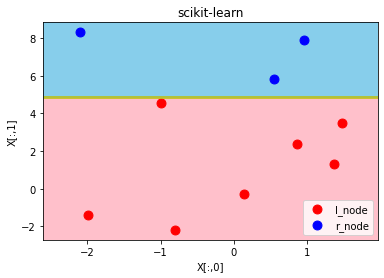

In [23]:
# scikit-learn可視化
decision_region(X_test,y_pred_tree,tr,step=0.01,title='scikit-learn', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])

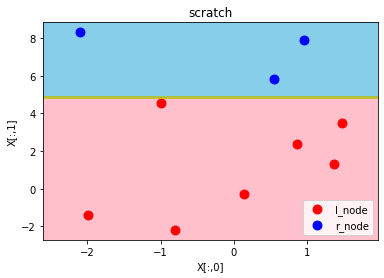

In [24]:
# scratch可視化
decision_region(X_test,scratch_pred,tr,step=0.01,title='scratch', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])

決定領域でも同じように引けている。

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。



### 【解答】指標値
すでに問題4でやってしまったため、ここでは指標値を算出する。

In [25]:
# 正解率とか出す関数
def index_out(y, pred, label,outlist={}):
    cm = confusion_matrix(y, pred)
    ac = metrics.accuracy_score(y, pred)
    pr = metrics.precision_score(y, pred)
    rc = metrics.recall_score(y, pred)
    f1 = metrics.f1_score(y, pred)

    print('confusion matrix =', cm)
    print('accuracy = ', ac)
    print('precision = ', pr)
    print('recall = ', rc)
    print('f1 score = ', f1)

    outlist[label] = [cm, ac, pr, rc, f1]
    return outlist


In [26]:
outlist={}
outlist = index_out(y_test, scratch_pred, "scratch")
outlist = index_out(y_test, y_pred_tree, "scikit-learn")

confusion matrix = [[4 1]
 [3 2]]
accuracy =  0.6
precision =  0.6666666666666666
recall =  0.4
f1 score =  0.5
confusion matrix = [[4 1]
 [3 2]]
accuracy =  0.6
precision =  0.6666666666666666
recall =  0.4
f1 score =  0.5


各指標値は低いが、depth=1なので当然。しかしscikit-learnとは同じ数字になっており、スクラッチが上手く動いていると考えられる。

# 【問題6】決定領域の可視化
決定領域を可視化してください。



### 【解答】可視化

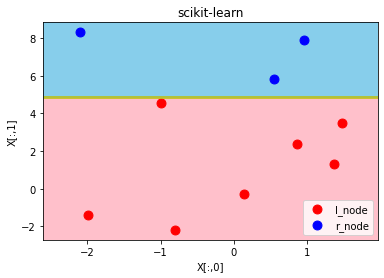

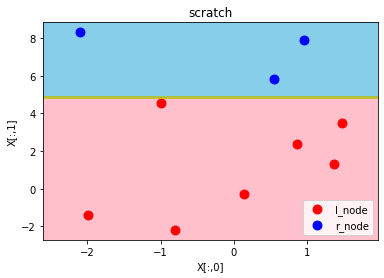

In [27]:
# scikit-learn可視化
decision_region(X_test,y_pred_tree,tr,step=0.01,title='scikit-learn', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])
# scratch可視化
decision_region(X_test,scratch_pred,tr,step=0.01,title='scratch', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])

# 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。


深さ2とは空間の分割を2回行うことを指します。


《ヒント》


各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。



### 【解答】問題7用のクラス

In [38]:
class _Node:
    """決定木のノードを生成するクラス"""
    
    def __init__(self, depth=0):
        """初期化処理
        depth : 現在の階層
        left : 左の子ノード
        right : 右の子ノード
        feature : 分割する特徴量のcolumn番号
        threshold : 分割する閾値
        label : クラス
        num_data : データの行数
        ig : 分割指標(情報利得)
        """
        self.depth = depth
        self.l_node = None
        self.r_node = None
        self.feature = None
        self.threshold = None
        self.label = None
        self.n_data = None
        self.ig = None
        
    def build(self, data, target, max_depth):
        """木の構築を行う
        data : ノードに与えられたデータ
        target : データの分類クラス
        
        """
        

        self.max_depth = max_depth
        print("mydepth : {}".format(self.depth))
        print("max_depth :{}".format(self.max_depth))
        self.n_data = data.shape[0]
        n_features = data.shape[1]
        
        # 自分のクラスを設定
        classes, counts = np.unique(target, return_counts=True) 
        self.label = counts.argmax() 
        
        # max_depthに到達してたら終わり
        if self.depth >= max_depth:
            print("Reach for the max depth.")
            return
        
        # 全部同一クラスでも終わり
        if len(classes) == 1:
            print("This node is a single class")
            return
        
        
        # 最良の分割を記憶する変数
        best_ig = 0.0
        best_feature = None
        best_threshold =None

        # 自分の不純度
        self.gini = self._ginis_diversity_index(target)
        
        
        # 特徴量ごとに分割していく
        for f in range(n_features):
            for threshold in data:
                index_classifier = data[:,f] <  threshold[f]
                target_l = target[index_classifier]
                target_r = target[~index_classifier]

                # 分割後の不純度から情報利得を計算
                ig = self._information_gain(target_l, target_r)
                
                # より良い分割であれば保存
                if ig > best_ig:
                    best_ig = ig
                    best_feature = f
                    best_threshold = threshold
                l_unique_class, l_counts = np.unique(target_l, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                r_unique_class, r_counts = np.unique(target_r, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                #print("left_unique: {}, l_counts :{}, r_unique_class :{}, r_counts :{}".format(l_unique_class, l_counts, r_unique_class, r_counts))
                #print("feature : {}, threshold :{}, ig :{}, left_shape[0] :{}, right_shape[0] :{}".format(f, threshold,ig,  target_l.shape[0],target_r.shape[0]))
                    
        
        # 最良の分割をインスタンス化
        self.ig = best_ig
        self.feature = best_feature
        self.threshold = best_threshold
        
        
        #print("best_threshold :{}".format(best_threshold))
        #print("best_feature :{}".format(best_feature))
        #print("best_ig :{}".format(best_ig))
        
        
        # 次のノードに進むための準備
        
        # dataとtargetを実際に分割する
        #print(data[:,self.feature])
        #print(self.threshold[self.feature])
        index_classifier = data[:,self.feature] < self.threshold[self.feature]
        data_l = data[index_classifier]
        data_r = data[~index_classifier]
        target_l = target[index_classifier]
        target_r = target[~index_classifier]
        
        _, l_counts = np.unique(target_l, return_counts=True)
        _, r_counts = np.unique(target_r, return_counts=True)
        self.l_label = l_counts.argmax() 
        self.r_label = r_counts.argmax() 
        
        # 次の深さ
        next_depth = self.depth + 1
        
        # 子ノードをインスタンス化して再帰処理
        self.l_node = _Node(next_depth)
        self.l_node.build(data_l, target_l, max_depth)
        
        self.r_node = _Node(next_depth)
        self.r_node.build(data_r, target_r, max_depth)
        
        
        
    
    # ジニ不純度を計算する関数
    def _ginis_diversity_index(self, target):
        _, counts = np.unique(target, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        n_all = len(target) # arrayのサンプル総数

        # giniの計算
        gini = 1 - (np.sum((counts / n_all)**2))

        return gini
    
    
    # 情報利得を計算する関数
    def _information_gain(self, left, right):
        n_l = left.shape[0] # arrayのサンプル総数
        n_r = right.shape[0] # arrayのサンプル総数

        left_gini = self._ginis_diversity_index(left)
        right_gini = self._ginis_diversity_index(right)
        
        ig = self.gini - n_l / self.n_data * left_gini - n_r / self.n_data * right_gini

        return ig
    
    
    def predict(self, d):
        """
        入力データ(単一)の分類先クラスを返す
        """
        #pred = np.where(data < self.threshold, self.l_label, self.r_label)[:,self.feature]
        
        #print(d[self.feature])
        
        #print("判定する特徴量 :{}".format(d))
        #print("現在のラベル :{}".format(self.label))
        #print("現在のself.feature:{}".format(self.feature))
        #print("現在のself.depth:{}".format(self.depth))
        
        
        if self.feature == None or self.depth == self.max_depth:
            return self.label
        
        else:
            if d[self.feature] < self.threshold[self.feature]:
                #print(self.feature)
                return self.l_node.predict(d)
            else:
                return self.r_node.predict(d)
        
        
class ScratchDecesionTreeClassifierDepth2:
    
    def __init__(self, max_depth=None):
        self.root_node = None
        self.max_depth = max_depth
            
            
    # メイン部分
    def fit(self, data, target):
        """学習を行い決定木を構築する
        data : 学習データ
        target : データの分類クラス
            
        """
        self.root_node = _Node()
        self.root_node.build(data, target, self.max_depth)
            
            
    # 推測する
    def predict(self, data):
        """
        決定木分類器を使いラベルを推定する
        """
        ans = []
        
        for d in data:
            ans.append(self.root_node.predict(d))
        return np.array(ans)
            
            

        
    

In [39]:
depth2 = ScratchDecesionTreeClassifierDepth2(max_depth=2)


In [40]:
depth2.fit(X_train,y_train)

mydepth : 0
max_depth :2
mydepth : 1
max_depth :2
mydepth : 2
max_depth :2
Reach for the max depth.
mydepth : 2
max_depth :2
Reach for the max depth.
mydepth : 1
max_depth :2
mydepth : 2
max_depth :2
Reach for the max depth.
mydepth : 2
max_depth :2
Reach for the max depth.


In [41]:
pred = depth2.predict(X_test)
pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

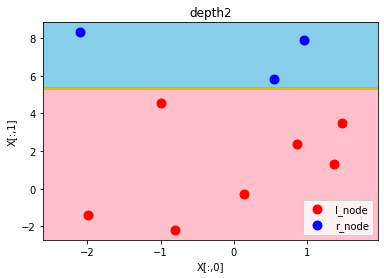

In [42]:
# 可視化
decision_region(X_test,pred, depth2,step=0.01,title='depth2', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])

### 【検証】scikit-learnとの比較、可視化

In [43]:
# scikit-learnで推測
tr2 = tree.DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
y_pred_tree_2 = tr2.predict(X_test)

print(y_pred_tree_2)
print(y_test)

[1 0 0 0 0 0 0 0 1 1]
[1 1 1 0 0 0 1 0 0 1]


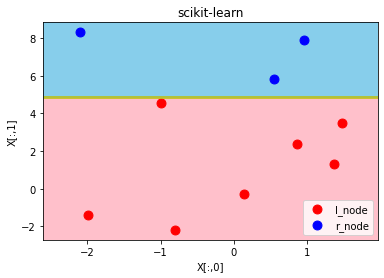

In [44]:
# scikit-learn可視化
decision_region(X_test,y_pred_tree_2,tr2,step=0.01,title='scikit-learn', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['l_node', 'r_node'])

max_depth2でも大体同じ結果になった。

# 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

### 【解答】問題8用のクラス

In [45]:
class _Node:
    """決定木のノードを生成するクラス"""
    
    def __init__(self, depth=0):
        """初期化処理
        depth : 現在の階層
        left : 左の子ノード
        right : 右の子ノード
        feature : 分割する特徴量のcolumn番号
        threshold : 分割する閾値
        label : クラス
        num_data : データの行数
        ig : 分割指標(情報利得)
        """
        self.depth = depth
        self.l_node = None
        self.r_node = None
        
        self.threshold = None
        self.label = None
        self.n_data = None
        self.ig = None
        
    def build(self, data, target, max_depth):
        """木の構築を行う
        data : ノードに与えられたデータ
        target : データの分類クラス
        
        """
        
        self.feature = None
        self.max_depth = max_depth
        #print("mydepth : {}".format(self.depth))
        #print("max_depth :{}".format(self.max_depth))
        self.n_data = data.shape[0]
        n_features = data.shape[1]
        
        # 自分のクラスを設定
        classes, counts = np.unique(target, return_counts=True) 
        if len(classes) == 1:
            self.label = classes[0]
        else:
            self.label = counts.argmax() 

        #print("==================")
        #print("現在のノードのサンプル数:{}".format(self.n_data))
        #print("現在のノードのクラス比率:{}".format(counts))
        #print("現在のノードの深さ:{}".format(self.depth))
        #print("現在のノードのクラス:{}".format(self.label))
        #print("==================")
        
        
        # max_depthに到達してたら終わり
        if max_depth == None:
            pass
        elif self.depth >= max_depth:
            #print("Reach for the max depth.")
            return
        
        # 全部同一クラスでも終わり
        if len(classes) == 1:
            #print("This node is a single class")
            return
        
        
        # 最良の分割を記憶する変数
        best_ig = 0.0
        best_feature = None
        best_threshold =None

        # 自分の不純度
        self.gini = self._ginis_diversity_index(target)
        
        
        # 特徴量ごとに分割していく
        for f in range(n_features):
            for threshold in data:
                index_classifier = data[:,f] <  threshold[f]
                target_l = target[index_classifier]
                target_r = target[~index_classifier]

                # 分割後の不純度から情報利得を計算
                ig = self._information_gain(target_l, target_r)
                
                # より良い分割であれば保存
                if ig > best_ig:
                    best_ig = ig
                    best_feature = f
                    best_threshold = threshold
                l_unique_class, l_counts = np.unique(target_l, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                r_unique_class, r_counts = np.unique(target_r, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
                #print("left_unique: {}, l_counts :{}, r_unique_class :{}, r_counts :{}".format(l_unique_class, l_counts, r_unique_class, r_counts))
                #print("feature : {}, threshold :{}, ig :{}, left_shape[0] :{}, right_shape[0] :{}".format(f, threshold,ig,  target_l.shape[0],target_r.shape[0]))
                    
        
        # 最良の分割をインスタンス化
        self.ig = best_ig
        self.feature = best_feature
        self.threshold = best_threshold

        
        #print("best_threshold :{}".format(best_threshold))
        #print("best_feature :{}".format(best_feature))
        #print("best_ig :{}".format(best_ig))
        
        
        # 次のノードに進むための準備
        
        # dataとtargetを実際に分割する
        #print(data[:,self.feature])
        #print(self.threshold[self.feature])
        index_classifier = data[:,self.feature] < self.threshold[self.feature]
        data_l = data[index_classifier]
        data_r = data[~index_classifier]
        target_l = target[index_classifier]
        target_r = target[~index_classifier]
        
        _, l_counts = np.unique(target_l, return_counts=True)
        _, r_counts = np.unique(target_r, return_counts=True)
        self.l_label = l_counts.argmax() 
        self.r_label = r_counts.argmax() 
        
        # 次の深さ
        next_depth = self.depth + 1
        
        # 子ノードをインスタンス化して再帰処理
        self.l_node = _Node(next_depth)
        self.l_node.build(data_l, target_l, max_depth)
        
        self.r_node = _Node(next_depth)
        self.r_node.build(data_r, target_r, max_depth)
        
        
        
    
    # ジニ不純度を計算する関数
    def _ginis_diversity_index(self, target):
        _, counts = np.unique(target, return_counts=True) # arrayの中のクラスとそれぞれの個数を抽出
        n_all = len(target) # arrayのサンプル総数

        # giniの計算
        gini = 1 - (np.sum((counts / n_all)**2))

        return gini
    
    
    # 情報利得を計算する関数
    def _information_gain(self, left, right):
        n_l = left.shape[0] # arrayのサンプル総数
        n_r = right.shape[0] # arrayのサンプル総数

        left_gini = self._ginis_diversity_index(left)
        right_gini = self._ginis_diversity_index(right)
        
        ig = self.gini - n_l / self.n_data * left_gini - n_r / self.n_data * right_gini

        return ig
    
    
    def predict(self, d):
        """
        入力データ(単一)の分類先クラスを返す
        """
        #pred = np.where(data < self.threshold, self.l_label, self.r_label)[:,self.feature]
        
        #print(d[self.feature])
        
        #print("判定する特徴量 :{}".format(d[self.feature]))
        #print("現在のラベル :{}".format(self.label))
        #print("現在のself.feature:{}".format(self.feature))
        #print("現在のself.depth:{}".format(self.depth))
        
        
        if self.feature == None or self.depth == self.max_depth:
            return self.label
        
        else:
            if d[self.feature] < self.threshold[self.feature]:
                #print(self.feature)
                return self.l_node.predict(d)
            else:
                return self.r_node.predict(d)
        
        
class ScratchDecesionTreeClassifierinf:
    
    def __init__(self, max_depth=None):
        self.root_node = None
        self.max_depth = max_depth
            
            
    # メイン部分
    def fit(self, data, target):
        """学習を行い決定木を構築する
        data : 学習データ
        target : データの分類クラス
            
        """
        self.root_node = _Node()
        self.root_node.build(data, target, self.max_depth)
            
            
    # 推測する
    def predict(self, data):
        """
        決定木分類器を使いラベルを推定する
        """
        ans = []
        
        for d in data:
            ans.append(self.root_node.predict(d))
        return np.array(ans)
            
            

        
    

In [46]:
final = ScratchDecesionTreeClassifier()

In [47]:
final.fit(X_train, y_train)

In [48]:
predict = final.predict(X_test)
predict

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

### 【検証】scikit-learnとの比較、可視化

In [49]:
# scikit-learnで推測
trinf = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred_tree_inf = trinf.predict(X_test)

y_pred_tree_inf

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [50]:
pd.DataFrame(data=[y_test,y_pred_tree_inf, predict], index=["y_test", "scikit-learn", "scratch"]).T

,y_test,scikit-learn,scratch
0,1,1,1
1,1,1,1
2,1,1,1
3,0,0,0
4,0,0,0
5,0,1,1
6,1,0,0
7,0,0,0
8,0,0,0
9,1,1,1


__index5,6を誤判定しているが、scikit-learnと同じ挙動なので、むしろちゃんとスクラッチできていると思われる。__

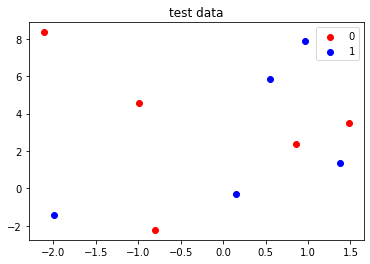

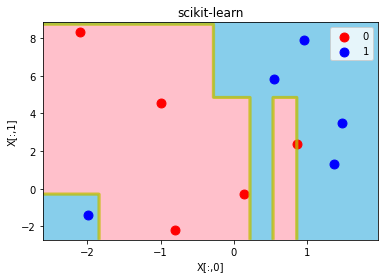

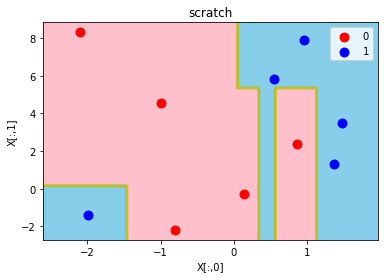

In [52]:
# y_testをプロット
plt.title("test data")
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='r', label='0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='b', label='1')
plt.legend()
plt.show()


# scikit-learn可視化
decision_region(X_test,y_pred_tree_inf,trinf,step=0.01,title='scikit-learn', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['0', '1'])
# scratch可視化
decision_region(X_test,predict,final,step=0.01,title='scratch', xlabel='X[:,0]', ylabel='X[:,1]', target_names=['0', '1'])

scikit-learnとほぼ同じ結果が得られた。

In [55]:
outlist = index_out(y_test, pred, "scratch_depth2")
outlist = index_out(y_test, y_pred_tree_2, "scikit-learn_depth2")
outlist = index_out(y_test, predict, "scratch_inf")
outlist = index_out(y_test, y_pred_tree_inf, "scikit-learn_inf")

confusion matrix = [[4 1]
 [3 2]]
accuracy =  0.6
precision =  0.6666666666666666
recall =  0.4
f1 score =  0.5
confusion matrix = [[4 1]
 [3 2]]
accuracy =  0.6
precision =  0.6666666666666666
recall =  0.4
f1 score =  0.5
confusion matrix = [[4 1]
 [1 4]]
accuracy =  0.8
precision =  0.8
recall =  0.8
f1 score =  0.8000000000000002
confusion matrix = [[4 1]
 [1 4]]
accuracy =  0.8
precision =  0.8
recall =  0.8
f1 score =  0.8000000000000002


In [58]:
result = pd.DataFrame(outlist)
result

,scratch,scikit-learn,scratch_depth2,scikit-learn_depth2,scratch_inf,scikit-learn_inf
0,"[[4, 1], [3, 2]]","[[4, 1], [3, 2]]","[[4, 1], [3, 2]]","[[4, 1], [3, 2]]","[[4, 1], [1, 4]]","[[4, 1], [1, 4]]"
1,0.6,0.6,0.6,0.6,0.8,0.8
2,0.667,0.667,0.667,0.667,0.8,0.8
3,0.4,0.4,0.4,0.4,0.8,0.8
4,0.5,0.5,0.5,0.5,0.8,0.8
